# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


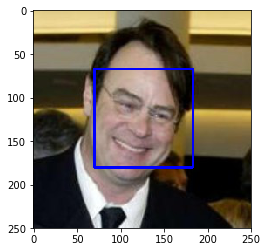

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

tot_hum = []
for img in tqdm(human_files_short):
    tot_hum.append(face_detector(img))
print(f"Percentage of human faces detected in first 100 images of human_files {sum(tot_hum)/len(human_files_short)*100}%")
print()
dog_hum = []
for img in tqdm(dog_files_short):
    dog_hum.append(face_detector(img))
print(f"Percentage of human faces detected in first 100 images of dog_files {sum(dog_hum)/len(dog_files_short)*100}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of human faces detected in first 100 images of human_files 98.0%



100%|██████████| 100/100 [00:29<00:00,  7.23it/s]

Percentage of human faces detected in first 100 images of dog_files 17.0%


Number of faces detected: 1


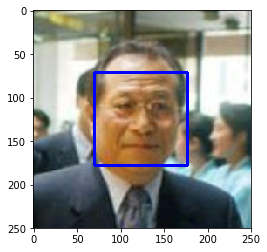

In [5]:
# extract pre-trained face detector
alternative_face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

# load color (BGR) image
img = cv2.imread(human_files[11])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))    
    
# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [6]:
def alternative_face_detector(img_path, path_to_detector):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(path_to_detector)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [7]:
path = 'haarcascades/haarcascade_frontalface_alt2.xml'
tot_hum = []
for img in tqdm(human_files_short):
    tot_hum.append(alternative_face_detector(img, path))
print(f"Percentage of human faces detected in first 100 images of human_files {sum(tot_hum)/len(human_files_short)*100}%")
print()
dog_hum = []
for img in tqdm(dog_files_short):
    dog_hum.append(alternative_face_detector(img, path))
print(f"Percentage of human faces detected in first 100 images of dog_files {sum(dog_hum)/len(dog_files_short)*100}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of human faces detected in first 100 images of human_files 100.0%



100%|██████████| 100/100 [00:30<00:00,  3.28it/s]

Percentage of human faces detected in first 100 images of dog_files 21.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 108254241.73it/s]



Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In [9]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    img  = Image.open(img_path)
    
    min_img_size = 224
    prepare_img = transforms.Compose([transforms.Resize(min_img_size),
                                      transforms.CenterCrop(min_img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    img = prepare_img(img)
    img = img.unsqueeze(0)
    
    use_cuda = torch.cuda.is_available()
    
    if use_cuda:
        img = img.cuda()

    prediction = VGG16(img)
    
    if use_cuda:
        prediction = prediction.cpu()
     
    class_index = prediction.data.numpy().argmax()

    return class_index # predicted class index

In [10]:
VGG16_predict(dog_files_short[0])

243

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).


In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    predicted_index = VGG16_predict(img_path)
    if 151 <= predicted_index <= 268:
        return True
    else:
        return False

In [12]:
dog_detector(dog_files_short[0])

True

### Assess the Dog Detector

In [13]:
tot_hum = []
for img in tqdm(human_files_short):
    tot_hum.append(dog_detector(img))
print(f"Percentage of dogs detected in first 100 images of human_files {sum(tot_hum)/len(human_files_short)*100}%")
print()
dog_hum = []
for img in tqdm(dog_files_short):
    dog_hum.append(dog_detector(img))
print(f"Percentage of dogs detected in first 100 images of dog_files {sum(dog_hum)/len(dog_files_short)*100}%")

  3%|▎         | 3/100 [00:00<00:03, 26.78it/s]

Percentage of dogs detected in first 100 images of human_files 0.0%



100%|██████████| 100/100 [00:04<00:00, 24.79it/s]

Percentage of dogs detected in first 100 images of dog_files 100.0%


### Alternative Pre-trained Network

In [14]:
def load_network(architecture, use_cuda):
    '''
    Load another pre-trained network
    Args:
        architecture: name of pre-trained network(i.e. resnet50)
    Returnd: Pre-trained network architecture
    '''
    network = eval('models.'+architecture+"(pretrained=True)")
    # move model to GPU if CUDA is available
    if use_cuda:
        network = network.cuda()
    return network

def network_predict(img_path, use_cuda, network):
    '''
    Use pre-trained network to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        network: pre-trained network (i.e. resnet50)
        
    Returns:
        Index corresponding to model's prediction
    '''
    img  = Image.open(img_path)
    
    min_img_size = 224
    prepare_img = transforms.Compose([transforms.Resize(min_img_size),
                                      transforms.CenterCrop(min_img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    img = prepare_img(img)
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
    
    prediction = network(img)
    
    if use_cuda:
        prediction = prediction.cpu()
     
    class_index = prediction.data.numpy().argmax()

    return class_index # predicted class index

In [15]:
def alternative_dog_detector(img_path, use_cuda, network):
    predicted_index = network_predict(img_path, use_cuda, network)
    if 151 <= predicted_index <= 268:
        return True
    else:
        return False

In [16]:
network = load_network('vgg11', use_cuda)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:09<00:00, 57924770.90it/s] 


In [17]:

tot_hum = []
for img in tqdm(human_files_short):
    tot_hum.append(alternative_dog_detector(img, use_cuda, network))
print(f"Percentage of dogs detected in first 100 images of human_files {sum(tot_hum)/len(human_files_short)*100}%")
print()
dog_hum = []
for img in tqdm(dog_files_short):
    dog_hum.append(alternative_dog_detector(img, use_cuda, network))
print(f"Percentage of dogs detected in first 100 images of dog_files {sum(dog_hum)/len(dog_files_short)*100}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of dogs detected in first 100 images of human_files 2.0%



100%|██████████| 100/100 [00:03<00:00, 29.49it/s]

Percentage of dogs detected in first 100 images of dog_files 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

In [18]:
data_dir = '/data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [19]:
import os
from torchvision import datasets

data_transforms = {'train':transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224), 
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ToTensor(), 
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])]), 
                   
                    'test':transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224), 
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])]), 
                   
                    'valid':transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224), 
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                                     [0.229, 0.224, 0.225])])}


image_datasets = {data: datasets.ImageFolder(data_dir+'/'+data, 
                                             transform=data_transforms[data]) 
                  for data in ['train', 'valid', 'test']}

dataloaders = {data: torch.utils.data.DataLoader(image_datasets[data], batch_size=32, shuffle = True) 
                 for data in ['train', 'valid', 'test']}

**Question 3:** Describe your chosen procedure for preprocessing the data. 

**Answer**:

For the data augmentation part, the code applies the following transformations to the **training** images:

- Randomly rotates the image in a 30 degree angle.
- Randomly flips the image horizontally.
- Takes a 224x224 square out of the center of the image.
- Normalizes the color channels to the defaults of Pytorch's pretrained networks.

These transformations allow the network to better generalize by introducing randomness as it sees the same images in different scales, with different locations, sizes and orientations.

With respect to the validation and test datasets, I decided to resize the images to a 256x256 size. There is no specific reason for picking this number, the main point is to reshape all images into homogenous squares regardless of the original size. In addition to this, I decided to keep Pytorch's default input size for pretrained networks by taking a center crop os size 224. Finally, all images are normalized o the defaults of Pytorch's pretrained networks

### Visualize Sample From Training Set vs Validation Set

In [20]:
images, labels = next(iter(dataloaders['train']))
valid_images, valid_labels = next(iter(dataloaders['valid']))

In [21]:
def show_image(img, ax=None):
    """
    Displays Pytorch Tensor into Image
    """
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    img = img.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    return ax

### Training

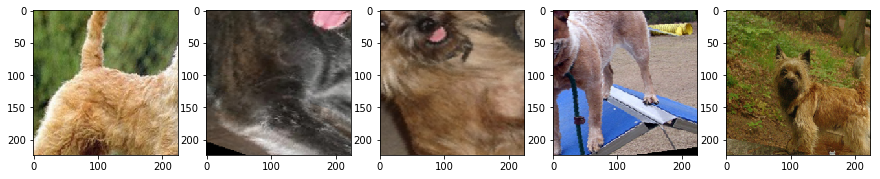

In [22]:
fig, axes = plt.subplots(figsize=(15,4), ncols=5)
for i in range(5):
    ax = axes[i]
    show_image(images[i], ax)

### Validation

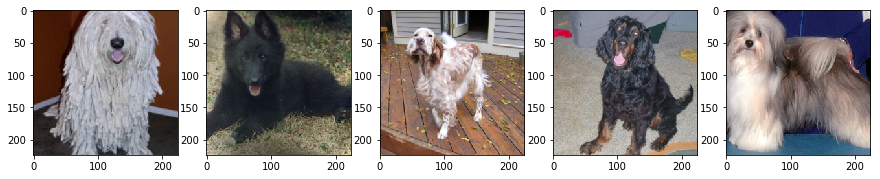

In [23]:
fig, axes = plt.subplots(figsize=(15,4), ncols=5)
for i in range(5):
    ax = axes[i]
    show_image(valid_images[i], ax)

### Model Architecture

In [24]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        ## Tensor input 3x224x224
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=32))
        ### Tensor Input 32x112x112
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=64)
        )
        ### Tensor Input 64x56x56
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=64)
        )

        self.drop_out = nn.Dropout(0.3)
        ### Tensor Input 64x28x28
        self.fc1 = nn.Linear(28 * 28 * 64, 500)
        self.fc2 = nn.Linear(500, 133)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [25]:
model_scratch

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop_out): Dropout(p=0.3)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

In summary, the CNN architecture consists of 3 Convolutional layers with kernel size 3, stride 1 and padding 2. Each Covolutional layer is followed by a ReLU activation function and a MaxPooling Layer with kernel size 2 and stride 2. The output of this operation is normalized using a Batch Normalization Layer before being fed into the following block. I also specified a Drop-out layer to avoid overfitting the model with a drop-out probability equal to 0.3. After passing the third block of this architecture, the output is flattened and passed to an intermediate layer of 500 fully connected nodes before being fed into the final output layer with 133 nodes.

The reasoning to arrive at this architecture was the following:

Given the data loading and processing steps, we know that the input images 224 x 224 pixels. In additions to this, we know that we are using colored images so that any input tensor is of size 3 x 224 x 224.

The first Convolutional layer consists of 32 channels of 5 x 5 filters, stride 1 and padding. I chose these values for the stride and padding because I wanted to keep the size of the input and output tensors constant. The following [formula](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/) allows you to compute the output size from either a convolutional filtering or pooling operation:
 
 $$W_{out} = \frac{W_{in}-\text{Kernel Size} +2\cdot \text{Padding}}{\text{Stride}} +1$$
 
Therefore, to the ouput for any channel of the convolutional layer will be:

$$W_{\text{out_conv}} = \frac{224-\text{5} +2\cdot \text{2}}{\text{1}} +1 = \frac{223}{1} + 1 = 224$$

The Maxpooling layer samples down the data by a factor equal to the size of the stride, in this case 2. The size of the output after the maxpooling operation is given by the formula:

$$W_{\text{out_max}} = \frac{224-\text{2} +2\cdot \text{0}}{\text{2}} +1 = \frac{222}{2} + 1 = 112$$

After the maxpooling operation takes place, the output is normalized before being fed into the next block. The reason for doing this is that "the distribution of each layer's inputs changes during training, as the parameters of previous layers change" [Ioffe, S., & Szegedy, C. (2015)](https://arxiv.org/pdf/1502.03167v3.pdf). This phenomenon is known as *internal covariate shift* and Batch Normalization was proposed as a solution to this problem. Although Batch Normalization has proven to be very effective in training image classifiers, the exact reasons why it works are still a matter of theoretical discussions. However, among its many side effects, it appears that the primary one is that of regularization. [Dive Into Deep Learning](http://d2l.ai/chapter_convolutional-modern/batch-norm.html).

Block 2 and 3 of the CNN architecture follow a similar logic by keeping the input and output tensors constant. The only difference is that both blocks double the number of channels in the Convolutional layer to 64. Here is a summary of how kernel size, stride and padding values change the input/output size through these blocks:

**Conv Block2**

$$W_{\text{out_conv}} = \frac{112-\text{5} +2\cdot \text{2}}{\text{1}} +1 = \frac{111}{1} + 1 = 112$$

**MaxPool Block2**

$$W_{\text{out_max}} = \frac{112-\text{2} +2\cdot \text{0}}{\text{2}} +1 = \frac{110}{2} + 1 = 56$$


**Conv Block3**

$$W_{\text{out_conv}} = \frac{56-\text{5} +2\cdot \text{2}}{\text{1}} +1 = \frac{55}{1} + 6 = 56$$

**MaxPool Block3**

$$W_{\text{out_max}} = \frac{56-\text{2} +2\cdot \text{0}}{\text{2}} +1 = \frac{54}{2} + 1 = 28$$

### Specify Loss Function and Optimizer

In [26]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

In [27]:
loaders_scratch = dataloaders

In [28]:
### Truncated Image
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Train and Validate the Model

In [29]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model and train/validation losses"""
    # initialize tracker for minimum validation loss
    losses = []
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## Set gradients to zero
            optimizer.zero_grad()
            ## Forward Pass
            output = model.forward(data)
            loss = criterion(output, target)
            # Back pass
            loss.backward()
            # Optimizer step
            optimizer.step()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model.forward(data)
                loss = criterion(output.data, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        losses.append((train_loss, valid_loss))
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased from ({:.6f} to {:.6f}).'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model, losses

In [69]:
start = time.time()

# train the model
model_scratch, losses_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

end = time.time()
elapsed_time = end - start
print('Elapsed time: {:.1f}min {:.1f}sec'.format(elapsed_time//60, elapsed_time%60))

Epoch: 1 	Training Loss: 2.971949 	Validation Loss: 3.151338
Validation loss decreased from (inf to 3.151338).
Epoch: 2 	Training Loss: 2.934180 	Validation Loss: 3.000862
Validation loss decreased from (3.151338 to 3.000862).
Epoch: 3 	Training Loss: 2.913254 	Validation Loss: 2.974426
Validation loss decreased from (3.000862 to 2.974426).
Epoch: 4 	Training Loss: 2.914807 	Validation Loss: 3.009204
Epoch: 5 	Training Loss: 2.856313 	Validation Loss: 2.975708
Epoch: 6 	Training Loss: 2.876482 	Validation Loss: 3.089085
Epoch: 7 	Training Loss: 2.871776 	Validation Loss: 3.061056
Epoch: 8 	Training Loss: 2.848922 	Validation Loss: 3.080557
Epoch: 9 	Training Loss: 2.843337 	Validation Loss: 3.078617
Epoch: 10 	Training Loss: 2.874602 	Validation Loss: 3.059006
Epoch: 11 	Training Loss: 2.801978 	Validation Loss: 3.031533
Epoch: 12 	Training Loss: 2.802728 	Validation Loss: 3.004843
Epoch: 13 	Training Loss: 2.796367 	Validation Loss: 3.102774
Epoch: 14 	Training Loss: 2.740539 	Validat

In [74]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [75]:
plt.style.use('fivethirtyeight')

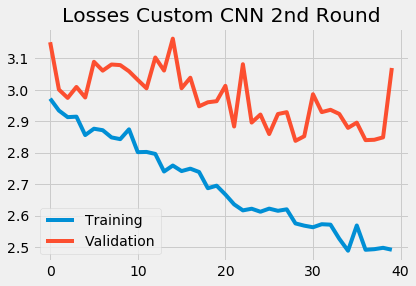

In [79]:
fig, ax = plt.subplots()
losses = np.array(losses_scratch)
plt.plot(losses.T[0], label='Training')
plt.plot(losses.T[1], label='Validation')
plt.title("Losses Custom CNN 2nd Round")
plt.legend()
plt.savefig('losses_custom_cnn_2nd_round.png')

### Test the Model

In [77]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [78]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.784835


Test Accuracy: 31% (263/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [35]:
loaders_transfer = {data: torch.utils.data.DataLoader(image_datasets[data], batch_size=32, shuffle = True) 
                 for data in ['train', 'valid', 'test']}

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [37]:
# Freeze network parameters
for param in VGG16.parameters():
    param.requires_grad = False

In [45]:
from collections import OrderedDict

def new_classifier(network, categories, drop_pr=0.2):
    """
    Define a new classifier to perform
    Transfer Learning task.
    Args:
    :network: Pre-trained network
    :categories: Number of categories to predict
    :drop_pr: Drop-out probability for hidden layers (default=0.2)
    Returns:
    :classifier
    """
    input_dim = network.classifier[0].in_features
    output_dim = network.classifier[0].out_features
    classifier = nn.Sequential(
        OrderedDict([('fc1', nn.Linear(input_dim, 12544, bias=False)),
                     ('bn1', nn.BatchNorm1d(12544)),
                     ('relu1', nn.ReLU()),
                     ('drop1', nn.Dropout(drop_pr)),
                     ('fc2', nn.Linear(12544, output_dim, bias=False)),
                     ('bn2', nn.BatchNorm1d(output_dim)),
                     ('relu2', nn.ReLU()),
                     ('drop2', nn.Dropout(drop_pr)),
                     ('fc3', nn.Linear(output_dim, categories))]))
    return classifier

In [46]:

import torchvision.models as models
import torch.nn as nn

classifier = new_classifier(VGG16, 133)

VGG16.classifier = classifier

model_transfer = VGG16

if use_cuda:
    model_transfer = model_transfer.cuda()

In [47]:
classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=12544, bias=False)
  (bn1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=12544, out_features=12544, bias=False)
  (bn2): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2)
  (fc3): Linear(in_features=12544, out_features=133, bias=True)
)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

In transfer learning, we take advantage of the "knowledge" of a model trained on a large dataset and *transfer* this knowledge to a smaller dataset. In this context, knowledge refers to weights of the convolutional layers of the **VGG16** model. Convolutional layers extract general, low-level features that are applicable across images (edges, patterns, gradients) and in this sense are universally applicable to any image.

The first step is to replace the classifier of the **VGG16** model with a custom classifier, a fully connected network, with the *correct* dimensions for the input and output layers. The classifier of the pre-trained **VGG16** model has an input dimension of 25,088, therefore the input layer of the `new_classifier` has to be of this size.

The next step was to decide the number of hidden layers and activation functions. I decided to build a very simple classifier with only a hidden layer with 12,544 input nodes, that is, half the number of nodes as the previous layer, and 4,096 output nodes ~1/6 of original input dimension. In addition to this, I added Drop-out layers (prob 0.2) to avoid overfitting when training the classifier and Batch Normalization layers to accelarate training and reduce internal covariance shift.

Finally, the output has a dimension equal to 133 representing each one of the different dog breeds in the dataset.




### Specify Loss Function and Optimizer

In [48]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

### Train and Validate the Model

In [49]:
# train the model
start = time.time()

model_transfer, losses_transfer = train(20,
                                        loaders_transfer,
                                        model_transfer,
                                        optimizer_transfer,
                                        criterion_transfer,
                                        use_cuda, 
                                        'model_transfer.pt')

end = time.time()
elapsed_time = end - start
print('Elapsed time: {:.1f}min {:.1f}sec'.format(elapsed_time//60, elapsed_time%60))

Epoch: 1 	Training Loss: 3.593855 	Validation Loss: 1.545212
Validation loss decreased from (inf to 1.545212).
Epoch: 2 	Training Loss: 2.042873 	Validation Loss: 0.943504
Validation loss decreased from (1.545212 to 0.943504).
Epoch: 3 	Training Loss: 1.571965 	Validation Loss: 0.745457
Validation loss decreased from (0.943504 to 0.745457).
Epoch: 4 	Training Loss: 1.333715 	Validation Loss: 0.600367
Validation loss decreased from (0.745457 to 0.600367).
Epoch: 5 	Training Loss: 1.226628 	Validation Loss: 0.567271
Validation loss decreased from (0.600367 to 0.567271).
Epoch: 6 	Training Loss: 1.108964 	Validation Loss: 0.503170
Validation loss decreased from (0.567271 to 0.503170).
Epoch: 7 	Training Loss: 1.074465 	Validation Loss: 0.502498
Validation loss decreased from (0.503170 to 0.502498).
Epoch: 8 	Training Loss: 1.010634 	Validation Loss: 0.479014
Validation loss decreased from (0.502498 to 0.479014).
Epoch: 9 	Training Loss: 1.001214 	Validation Loss: 0.491665
Epoch: 10 	Train

In [50]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

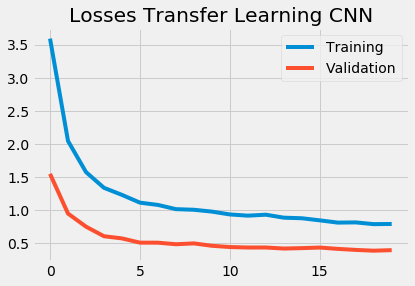

In [51]:
fig, ax = plt.subplots()
t_losses = np.array(losses_transfer)
plt.plot(t_losses.T[0], label='Training')
plt.plot(t_losses.T[1], label='Validation')
plt.title("Losses Transfer Learning CNN")
plt.legend()
plt.savefig('losses_transfer_cnn.png')

### Test the Model

In [52]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.466673


Test Accuracy: 84% (710/836)


### Predict Dog Breed with the Model  

In [53]:
data_transfer = image_datasets
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    use_cuda = torch.cuda.is_available()
    predicted_breed = network_predict(img_path, use_cuda, model_transfer)
    print(f"Predicted class index: {predicted_breed}")
    return class_names[predicted_breed]

In [54]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    min_img_size = 224
    prepare_img = transforms.Compose([transforms.Resize(min_img_size),
                                      transforms.CenterCrop(min_img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    img = prepare_img(img)
    return img

### Model Testing

In [55]:
print(f"File name: {dog_files_short[8]}")
print()
predict_breed_transfer(dog_files_short[8])

File name: /data/dog_images/train/103.Mastiff/Mastiff_06866.jpg

Predicted class index: 102


'Mastiff'

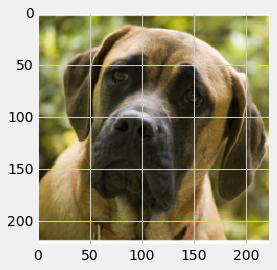

In [56]:
show_image(process_image(dog_files_short[8]))


In [57]:
print(f"File name: {dog_files_short[-1]}")
print()
predict_breed_transfer(dog_files_short[-1])

File name: /data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04173.jpg

Predicted class index: 58


'Doberman pinscher'

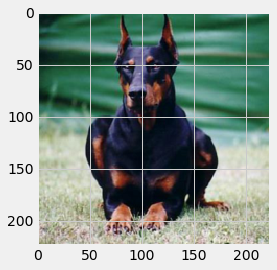

In [58]:
show_image(process_image(dog_files_short[-1]))

In [59]:
human_example = process_image(human_files[17])

In [71]:
def human_to_dog(img_path):
    """
    Given a path to a human image
    return the predicted image for the dog breed
    """
    human_pred_breed = predict_breed_transfer(img_path)
    print(f"Predicted Dog Breed: {human_pred_breed}")
    class_dict = {item[4:].replace("_", " "):item[:4].split('.')[0] for item in data_transfer['train'].classes}
    sample_idx = class_dict[human_pred_breed]
    breed_input = "_".join(human_pred_breed.split(" "))
    file_pick = os.listdir(f'/data/dog_images/train/{sample_idx}.{breed_input}')[-6]
    return process_image(f'/data/dog_images/train/{sample_idx}.{breed_input}/{file_pick}')

In [72]:
dog_example = human_to_dog(human_files[17])

Predicted class index: 119
Predicted Dog Breed: Pharaoh hound


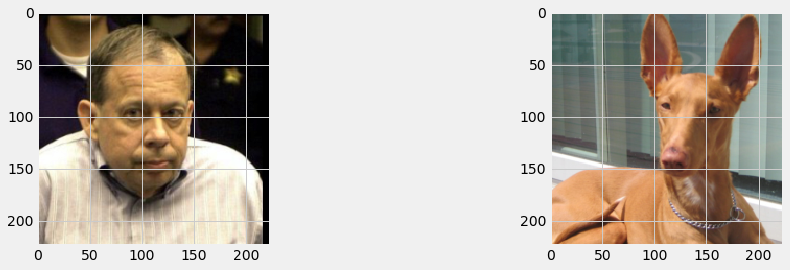

In [73]:
fig, axes = plt.subplots(figsize=(15,4), ncols=2)
for i, img in enumerate([human_example, dog_example]):
    ax = axes[i]
    show_image(img, ax)

### Last Check (Image Downloaded from Internet)

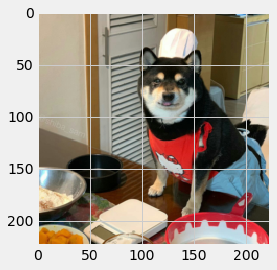

In [63]:
show_image(process_image('/home/workspace/dog_project/images/tumblr_pto11cJIo11rnbunpo1_1280.jpg'))

In [64]:
dog_detector('/home/workspace/dog_project/images/tumblr_pto11cJIo11rnbunpo1_1280.jpg')

False

In [65]:
alternative_dog_detector('/home/workspace/dog_project/images/tumblr_pto11cJIo11rnbunpo1_1280.jpg', use_cuda, network)

True

In [66]:
predict_breed_transfer('/home/workspace/dog_project/images/tumblr_pto11cJIo11rnbunpo1_1280.jpg')

Predicted class index: 47


'Chihuahua'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [67]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    use_cuda = torch.cuda.is_available()
    if face_detector(img_path) or alternative_dog_detector(img_path, use_cuda, network):
        return predict_breed_transfer(img_path)
    else:
        print(f"Error: The following image Does Not Belong to a Dog nor a Human: {img_path}")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Given the accuracy of the model for predicting canine breeds, 84%, the algorithm performed as expected on the sample images that I used. However, there is a lot of room for improvement, this can be seen in the sample image downloaded from the internet, a **Shiba Inu** wearing cooking clothes. Even though it is simple for the human eye to identify a dog in the image, the addition of clothing already causes the `dog_detector` to give a wrong prediction. 

Therefore, the first step to improve the algorithm would be to use a better dog detector for a given image. An example can be seen in the `alternative_dog_detector` function, which allows us to use any pre-trained network available in Pytorch for image classification, for example, **VGG11**. This alternative detector allows us to correctly predict that the image belongs to a dog.

A second step would be to increase the number of images in our training set by adding images of different dog breeds wearing clothes. It is not uncommon to see images in social media of pets wearing some form of clothing or costume, we would like our model to be able to abstract these details and focus on identifying the breed. This poses an interesting challenge to the current implementation as seen in the model prediction.

The model prediction for this image is a Chihuahua!!! We know this couldn't be further from the truth. Therefore, the third improvement would be to retrain the transfer model with this enhanced dataset. Models like **VGG16** were trained on the Imagenet dataset, which contains images for common clothing pieces like t-shirts, sweatshirts, etc. In this sense, we can rely on the weights of the pre-trained network to identify features that belong to clothing pieces, while the classifier can focus on learning the specific weights related to dog-breed-clothing combinations.

Finally, we could build a more complex classifier by increasing the number of hidden layers to better learn the specific features that differentiate dog breeds.


In [68]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

Predicted class index: 38
Predicted class index: 4
Predicted class index: 40
Predicted class index: 40
Predicted class index: 40
Predicted class index: 40
